# 1. Download data

In [1]:
import urllib.request

urllib.request.urlretrieve("https://opendata.rijdendetreinen.nl/public/tariff-distances/tariff-distances-2022-01.csv", "data/tariff-distances-2022-01.csv")
urllib.request.urlretrieve("https://opendata.rijdendetreinen.nl/public/stations/stations-2023-09.csv", "data/stations-2023-09.csv")

('data/stations-2023-09.csv', <http.client.HTTPMessage at 0x20369dd2420>)

In [2]:
import os

os.makedirs("data/disruptions", exist_ok=True)

for year in range(2011, 2024):
    urllib.request.urlretrieve(f"https://opendata.rijdendetreinen.nl/public/disruptions/disruptions-{year}.csv", f"data/disruptions/disruptions-{year}.csv")

In [3]:
import gzip
import shutil

os.makedirs("data/services", exist_ok=True)

for year in range(2019, 2025):
    gz_path = f"data/services/services-{year}.csv.gz"
    csv_path = f"data/services/services-{year}.csv"
    urllib.request.urlretrieve(f"https://opendata.rijdendetreinen.nl/public/services/services-{year}.csv.gz", gz_path)
    
    with gzip.open(gz_path, 'rb') as f_in:
        with open(csv_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    os.remove(gz_path)

    
for month in range(1, 10):
    gz_path = f"data/services/services-2025-{month}.csv.gz"
    csv_path = f"data/services/services-2025-{month}.csv"
    urllib.request.urlretrieve(f"https://opendata.rijdendetreinen.nl/public/services/services-2025-{month:02}.csv.gz", gz_path)
    
    with gzip.open(gz_path, 'rb') as f_in:
        with open(csv_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    os.remove(gz_path)

# 2. Put stations data into stations table in DuckDB. This changes rarely, so we treat it as a almost constant file.

In [4]:
import duckdb

db = duckdb.connect("data/duck_rail.db")
db.sql("""
CREATE TABLE IF NOT EXISTS stations AS
FROM read_csv("data/stations-2023-09.csv")
""")
db.sql("DESCRIBE")

┌───────────┬─────────┬──────────┬────────────────────────────────────────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────┬───────────┐
│ database  │ schema  │   name   │                                        column_names                                        │                                          column_types                                           │ temporary │
│  varchar  │ varchar │ varchar  │                                         varchar[]                                          │                                            varchar[]                                            │  boolean  │
├───────────┼─────────┼──────────┼────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────┼───────────┤
│ duck_rail │ main    │ stations │ [id, code, ui

# 3. Based on DuckDB tutorial, create tables distances and distances_long. We treat this similarly to stations table.

In [5]:
db.sql("""
CREATE TABLE IF NOT EXISTS distances AS
FROM read_csv("data/TARIFF-DISTANCES-2022-01.csv", nullstr = 'XXX')
""")

db.sql("""
FROM (DESCRIBE distances)
LIMIT 5;
""")

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Station     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ AC          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AH          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AHP         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AHPR        │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
└─────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [6]:
db.sql("""
CREATE TABLE distances_long AS
UNPIVOT distances
ON COLUMNS (* EXCLUDE station)
INTO NAME other_station VALUE distance;
""")

# 4. Put train disruptions into disruptions table in the Postgres database. We expect this data to change regularly, and thus treat it as a typical OLTP table.

In [64]:
db.sql("""INSTALL postgres; LOAD postgres;""")

conn_string = "host=localhost user=postgres password=postgres dbname=postgres"

db.sql(f"""
ATTACH IF NOT EXISTS '{conn_string}' AS postgres_db (TYPE postgres);
""")

files = [f"data/disruptions/disruptions-{year}.csv" for year in range(2011, 2024)]
db.sql(f"""
CREATE TABLE IF NOT EXISTS postgres_db.disruptions AS
FROM read_csv({files})
""")

# 5. Transform train services CSV files into a single Parquet file. Make table services from it. We treat this as a big data batch input, created rarely but regularly for analytics purposes.

In [11]:
files = []
for year in range(2019, 2025):
    csv_path = f"data/services/services-{year}.csv"
    files.append(csv_path)

    
for month in range(1, 10):
    csv_path = f"data/services/services-2025-{month}.csv"
    files.append(csv_path)
    

duckdb.sql(f"""
COPY (SELECT * FROM read_csv({files})) TO "data/services.parquet" (COMPRESSION zstd);
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [13]:
db.sql("""
CREATE TABLE IF NOT EXISTS services AS
FROM "data/services.parquet"
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [22]:
db.sql("SHOW TABLES FROM duck_rail")

┌────────────────┐
│      name      │
│    varchar     │
├────────────────┤
│ distances      │
│ distances_long │
│ services       │
│ stations       │
└────────────────┘

In [23]:
db.sql("SHOW TABLES FROM postgres_db")

┌─────────────┐
│    name     │
│   varchar   │
├─────────────┤
│ disruptions │
└─────────────┘

In [18]:
db.sql("SELECT COUNT(*) FROM services")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│    146556858 │
└──────────────┘

# 6. In all following questions, use tables services, distances_long, disruptions and stations as necessary. Remember that each row represents single ride between stations, while the whole end-to-end train service has the same value in Service:RDT-ID column. Note that starting station for a service has NULL value in Stop:Arrival time column, while the end station has NULL value in Stop:Departure time column.

# 7. Make queries to answer the following questions: 

In [50]:
db.sql("DESCRIBE services")

┌──────────────────────────────┬──────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│         column_name          │       column_type        │  null   │   key   │ default │  extra  │
│           varchar            │         varchar          │ varchar │ varchar │ varchar │ varchar │
├──────────────────────────────┼──────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ Service:RDT-ID               │ BIGINT                   │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Date                 │ DATE                     │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Type                 │ VARCHAR                  │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Company              │ VARCHAR                  │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Train number         │ BIGINT                   │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Completely cancelled │ BOOLEAN                  │ YES     │ NULL    │ NULL    │ NULL    │


In [49]:
db.sql("DESCRIBE stations")

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ id          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ code        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ uic         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ name_short  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ name_medium │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ name_long   │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ slug        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ country     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ type        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ geo_lat     │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ geo_lng     │ DOUB

In [56]:
db.sql("DESCRIBE postgres_db.disruptions")

┌──────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│     column_name      │ column_type │  null   │   key   │ default │  extra  │
│       varchar        │   varchar   │ varchar │ varchar │ varchar │ varchar │
├──────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ rdt_id               │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ ns_lines             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_lines            │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_lines_id         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_station_names    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_station_codes    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ cause_nl             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ cause_en             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ statistical_cause_nl │ VARCHAR     │ YES     │ NUL

In [60]:
db.sql("DESCRIBE distances")

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Station     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ AC          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AH          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AHP         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AHPR        │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AHZ         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AKL         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AKM         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ ALM         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ ALMB        │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│  ·          │   · 

In [59]:
db.sql("DESCRIBE distances_long")

┌───────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│  column_name  │ column_type │  null   │   key   │ default │  extra  │
│    varchar    │   varchar   │ varchar │ varchar │ varchar │ varchar │
├───────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Station       │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ other_station │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ distance      │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
└───────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

## 7.1 How many trains departed from Amsterdam Central station overall?
(amsterdam central nie istnieje :( jest amsterdam centr**aa**l)

In [53]:
db.sql("""
SELECT id, code, name_short, name_medium, name_long FROM stations
WHERE name_long LIKE 'Amsterdam%'
""")

┌───────┬─────────┬────────────┬────────────────┬─────────────────────────┐
│  id   │  code   │ name_short │  name_medium   │        name_long        │
│ int64 │ varchar │  varchar   │    varchar     │         varchar         │
├───────┼─────────┼────────────┼────────────────┼─────────────────────────┤
│    40 │ ASA     │ Amstel     │ Amstel         │ Amsterdam Amstel        │
│    41 │ ASB     │ Bijlmer A  │ Bijlmer ArenA  │ Amsterdam Bijlmer ArenA │
│    43 │ ASD     │ Amsterdm C │ Amsterdam C.   │ Amsterdam Centraal      │
│    47 │ ASHD    │ Holendrcht │ Holendrecht    │ Amsterdam Holendrecht   │
│    44 │ ASDL    │ Lelylaan   │ Lelylaan       │ Amsterdam Lelylaan      │
│    45 │ ASDM    │ Muiderprt  │ Muiderpoort    │ Amsterdam Muiderpoort   │
│   393 │ RAI     │ RAI        │ RAI            │ Amsterdam RAI           │
│    48 │ ASSP    │ Scienceprk │ Science Park   │ Amsterdam Science Park  │
│    50 │ ASS     │ Sloterdijk │ Sloterdijk     │ Amsterdam Sloterdijk    │
│    46 │ AS

In [54]:
db.sql("""
SELECT COUNT("Stop:Departure time") FROM services
WHERE "Stop:Station code" = 'ASD'
""")

┌──────────────────────────────┐
│ count("Stop:Departure time") │
│            int64             │
├──────────────────────────────┤
│                      1871852 │
└──────────────────────────────┘

## 7.2 Calculate the average arrival delay of different service types (Service:Type). Order results descending by average delay.

In [62]:
db.sql("""
SELECT "Service:Type" as type, AVG("Stop:Arrival delay") as avg_delay, FROM services
GROUP BY type
ORDER BY avg_delay DESC
""")

┌──────────────────────┬────────────────────┐
│         type         │     avg_delay      │
│       varchar        │       double       │
├──────────────────────┼────────────────────┤
│ Alpen Express        │  31.84254143646409 │
│ Krokus Express       │ 18.304347826086957 │
│ European Sleeper     │ 14.730917608156517 │
│ Nightjet             │  9.256974238121135 │
│ Eurostar             │  7.221416941972401 │
│ ICE International    │  5.482790573052148 │
│ Thalys               │ 5.3961896909446025 │
│ Int. Trein           │ 4.9727022780832675 │
│ Nachttrein           │ 3.7960975609756096 │
│ Stoomtrein           │  3.366863905325444 │
│  ·                   │                 ·  │
│  ·                   │                 ·  │
│  ·                   │                 ·  │
│ Bus                  │                0.0 │
│ Belbus ipv trein     │                0.0 │
│ Belbus               │                0.0 │
│ Snelbus i.p.v. trein │                0.0 │
│ Metro ipv trein      │          

## 7.3 What was the most common disruption cause in different years? MODE function may be useful.

In [69]:
db.sql("""
SELECT YEAR("start_time") as year, MODE("cause_en") as "most frequent disruption", COUNT("cause_en") as "disruption count" FROM postgres_db.disruptions
GROUP by year
ORDER BY year
""")

┌───────┬──────────────────────────┬──────────────────┐
│ year  │ most frequent disruption │ disruption count │
│ int64 │         varchar          │      int64       │
├───────┼──────────────────────────┼──────────────────┤
│  2011 │ broken down train        │             1839 │
│  2012 │ points failure           │             2071 │
│  2013 │ points failure           │             2279 │
│  2014 │ broken down train        │             2424 │
│  2015 │ broken down train        │             2899 │
│  2016 │ broken down train        │             2997 │
│  2017 │ broken down train        │             4085 │
│  2018 │ broken down train        │             5190 │
│  2019 │ broken down train        │             5940 │
│  2020 │ broken down train        │             4450 │
│  2021 │ broken down train        │             4874 │
│  2022 │ broken down train        │             5499 │
│  2023 │ broken down train        │             5168 │
├───────┴──────────────────────────┴────────────

## 7.4 How many trains started their overall service in any Amsterdam station?

In [71]:
db.sql("""
SELECT COUNT(*) FROM services
WHERE "Stop:Station name" ILIKE '%amsterdam%'
AND "Stop:Arrival time" IS NULL
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      1243175 │
└──────────────┘

## 7.5 What fraction of services was run to final destinations outside the Netherlands?

In [84]:
db.sql("""
SELECT COUNT(DISTINCT "Service:RDT-ID") / (SELECT COUNT(DISTINCT "Service:RDT-ID") FROM services) FROM services
JOIN stations ON "Stop:Station code" = "code"
WHERE country != 'NL' AND "Stop:Departure time" IS NULL
""")

┌──────────────────────────────────────────────────────────────────────────────────────────────┐
│ (count(DISTINCT "Service:RDT-ID") / (SELECT count(DISTINCT "Service:RDT-ID") FROM services)) │
│                                            double                                            │
├──────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                         0.037142935338268394 │
└──────────────────────────────────────────────────────────────────────────────────────────────┘

## 7.6 What is the largest distance between stations in the Netherlands (code NL)?

In [122]:
db.sql("""
SELECT Station, other_station, distance FROM distances_long
JOIN stations AS stations1 ON Station = stations1.code
JOIN stations AS stations2 ON other_station = stations2.code
WHERE stations1.country = 'NL' AND stations2.country = 'NL'
ORDER BY distance DESC
LIMIT 1
""")

┌─────────┬───────────────┬──────────┐
│ Station │ other_station │ distance │
│ varchar │    varchar    │  int64   │
├─────────┼───────────────┼──────────┤
│ VS      │ EEM           │      426 │
└─────────┴───────────────┴──────────┘

In [94]:
db.sql("""
SELECT Station, other_station, distance FROM distances_long
ORDER BY distance DESC
""")

┌─────────┬───────────────┬──────────┐
│ Station │ other_station │ distance │
│ varchar │    varchar    │  int64   │
├─────────┼───────────────┼──────────┤
│ VS      │ LEER          │      450 │
│ LEER    │ VS            │      450 │
│ VSS     │ LEER          │      449 │
│ LEER    │ VSS           │      449 │
│ MDB     │ LEER          │      444 │
│ LEER    │ MDB           │      444 │
│ LEER    │ ARN           │      440 │
│ ARN     │ LEER          │      440 │
│ VS      │ WR            │      435 │
│ WR      │ VS            │      435 │
│ ·       │ ·             │       ·  │
│ ·       │ ·             │       ·  │
│ ·       │ ·             │       ·  │
│ RLB     │ SKND          │      266 │
│ RSW     │ MTH           │      266 │
│ RTA     │ SDA           │      266 │
│ RTA     │ UST           │      266 │
│ RTA     │ VDM           │      266 │
│ RTA     │ WK            │      266 │
│ RTN     │ STM           │      266 │
│ RTST    │ ZH            │      266 │
│ RTZ     │ BP           

## 7.7 Compare the average arrival delay between different train operators (Service:Company) on a bar plot. Sort them appropriately.

<Axes: ylabel='company'>

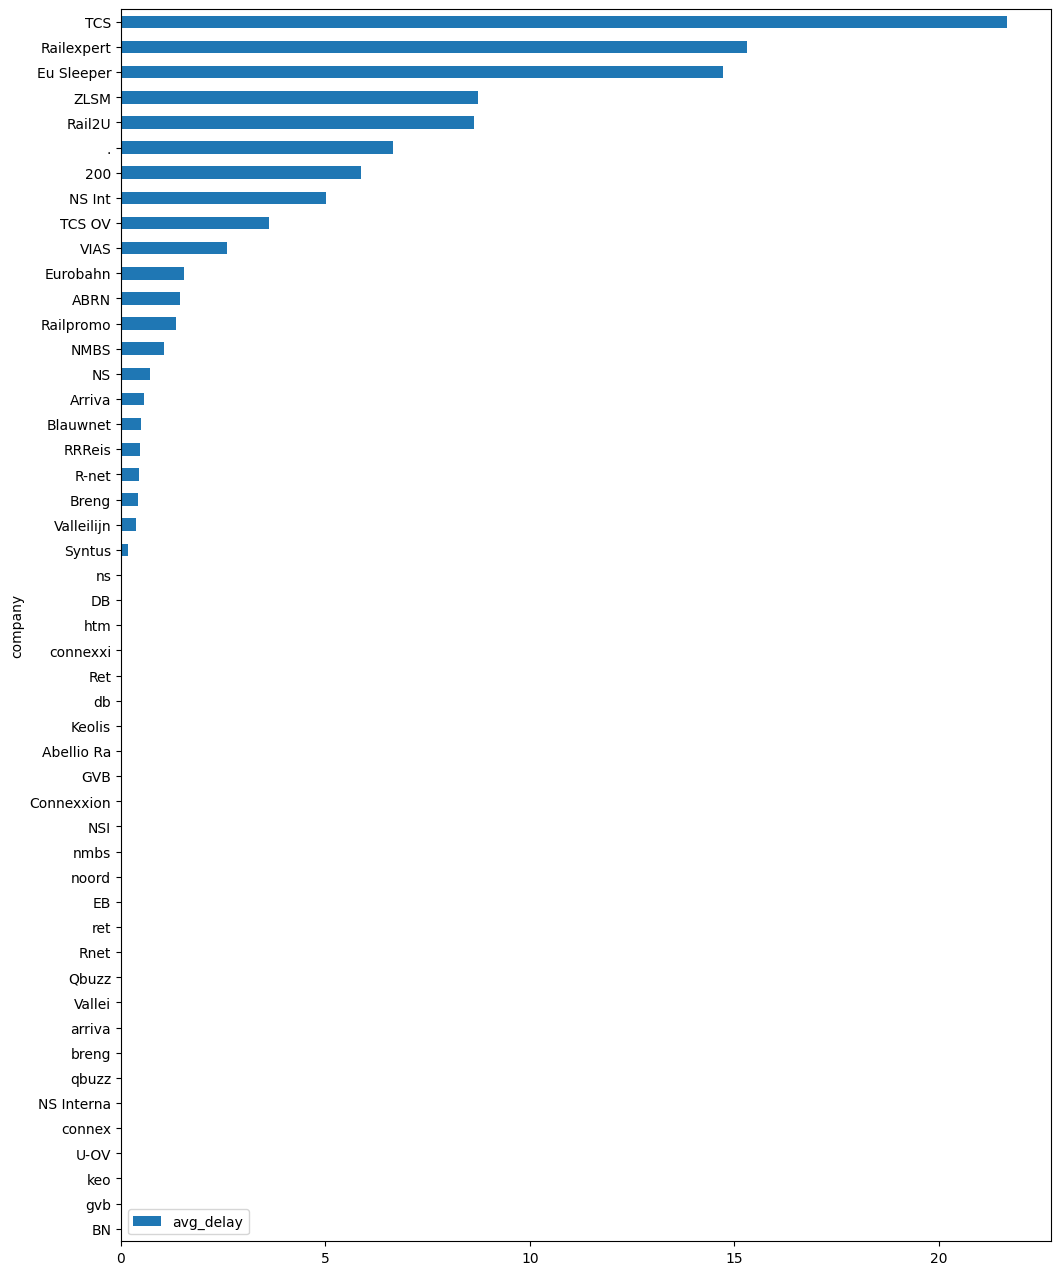

In [126]:
delay_df = db.sql("""
SELECT "Service:Company" as company, AVG("Stop:Arrival delay") as avg_delay FROM services
GROUP BY company
ORDER BY avg_delay ASC
""").df()
delay_df.plot.barh(x="company", figsize=(12,16))

## 7.8 How many services were disrupted in different years? Make a line plot.

<Axes: xlabel='year'>

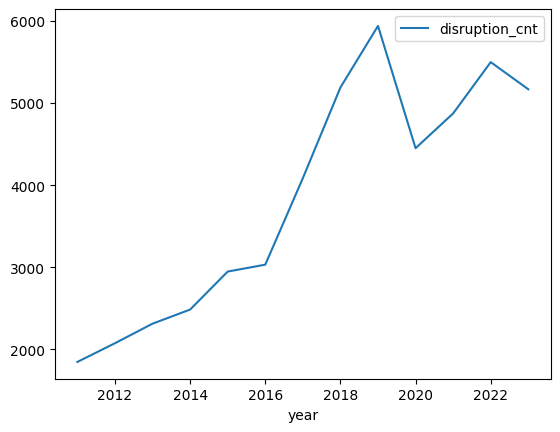

In [112]:
disruptions_df = db.sql("""
SELECT YEAR("start_time") as year, COUNT(DISTINCT "rdt_id") as "disruption_cnt" FROM postgres_db.disruptions
GROUP BY year
ORDER BY year
""").df()
disruptions_df.plot(x="year")

## 7.9 What fraction of all services were cancelled (Service:Completely cancelled) in different years? Make a line plot.
procent odwołanych w tym roku czy ogólnie? tzn.:
dla każdego roku:
(odwołane w tym roku)/(wszystkie we wszystkich latach):

<Axes: xlabel='year'>

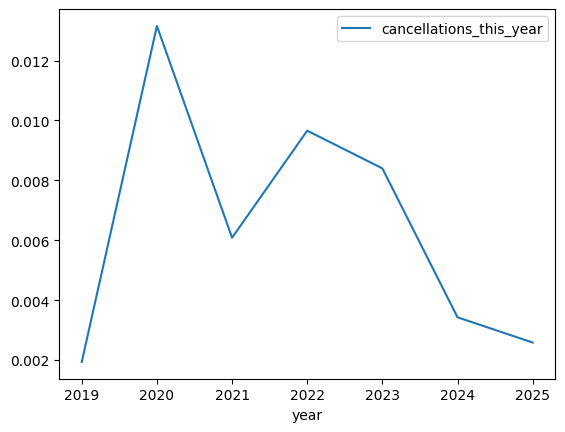

In [144]:
cancellations_df1 = db.sql("""
SELECT YEAR("Service:Date") AS year,
COUNT(DISTINCT CASE WHEN "Service:Completely cancelled" THEN "Service:RDT-ID" END) 
/ (SELECT COUNT(DISTINCT "Service:RDT-ID") FROM services) AS "cancellations_this_year"
FROM services
GROUP BY year
ORDER BY year
""").df()
cancellations_df1.plot(x="year")

czy:
(odwołane w tym roku)/(wszystkie w tym roku):

<Axes: xlabel='year'>

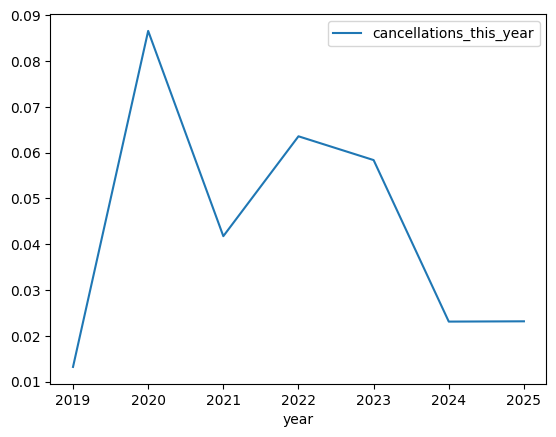

In [145]:
cancellations_df2 = db.sql("""
SELECT YEAR("Service:Date") AS year,
COUNT(DISTINCT CASE WHEN "Service:Completely cancelled" THEN "Service:RDT-ID" END) 
/ COUNT(DISTINCT "Service:RDT-ID") AS "cancellations_this_year"
FROM services
GROUP BY year
ORDER BY year
""").df()
cancellations_df2.plot(x="year")

# 8. Currently, services table does not provide information about service lengths, neither between pairs of stations nor for the end-to-end service. Prepare this information: 

- Note that each service has the same Service:RDT-ID, and stations can be ordered by Stop:Departure time, with the last one being NULL. Using window functions, specifically LAG() or LEAD(), you can get next row. This example may also be useful.
- Create table station_connections, with columns Service:RDT-ID, start_station_code and end_station_code (pair of stations on a route), and distance between them. Note that you should deduplicate the data on station codes, so that every station pair appears only once. Create temporary tables, use a subquery, or any other similar techniques if necessary.

In [156]:
db.sql("""
WITH consecutive_stops AS (
    SELECT "Service:RDT-ID" AS service_id, "Stop:Station code" AS start_station,
    LEAD("Stop:Station code") OVER (PARTITION BY "Service:RDT-ID" ORDER BY "Stop:Departure time") AS end_station
    FROM services
)
SELECT * FROM consecutive_stops
WHERE end_station IS NOT NULL
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬───────────────┬─────────────┐
│ service_id │ start_station │ end_station │
│   int64    │    varchar    │   varchar   │
├────────────┼───────────────┼─────────────┤
│     739065 │ HRL           │ HRLW        │
│     739065 │ HRLW          │ VDL         │
│     739065 │ VDL           │ KMR         │
│     739065 │ KMR           │ SOG         │
│     739065 │ SOG           │ VK          │
│     739065 │ VK            │ SGL         │
│     739065 │ SGL           │ MES         │
│     739065 │ MES           │ MTN         │
│     739065 │ MTN           │ MT          │
│     739065 │ MT            │ MTR         │
│        ·   │ ·             │  ·          │
│        ·   │ ·             │  ·          │
│        ·   │ ·             │  ·          │
│    1048715 │ HRL           │ HRLW        │
│    1048715 │ HRLW          │ VDL         │
│    1048715 │ VDL           │ KMR         │
│    1048715 │ KMR           │ SOG         │
│    1048715 │ SOG           │ VK          │
│    10487

In [157]:
db.sql("""
WITH consecutive_stops AS (
    SELECT "Service:RDT-ID" AS service_id, "Stop:Station code" AS start_station,
    LEAD("Stop:Station code") OVER (PARTITION BY "Service:RDT-ID" ORDER BY "Stop:Departure time") AS end_station
    FROM services
)
SELECT DISTINCT cs.service_id, cs.start_station, cs.end_station, d.distance FROM consecutive_stops AS cs
JOIN distances_long AS d ON cs.start_station = d.Station AND cs.end_station = d.other_station
WHERE cs.end_station IS NOT NULL
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬───────────────┬─────────────┬──────────┐
│ service_id │ start_station │ end_station │ distance │
│   int64    │    varchar    │   varchar   │  int64   │
├────────────┼───────────────┼─────────────┼──────────┤
│    8981507 │ RSD           │ DDR         │       38 │
│    8984105 │ UTLR          │ UT          │        3 │
│    8987189 │ DMNZ          │ WP          │        7 │
│    8989232 │ BSD           │ GDM         │        7 │
│    8994828 │ SHL           │ RTD         │       67 │
│    8996582 │ SHL           │ RTD         │       67 │
│    8997227 │ KTR           │ TL          │       12 │
│    8998468 │ UTLN          │ UTVR        │        3 │
│    8998618 │ NDB           │ AMPO        │       22 │
│    8999158 │ AC            │ ASHD        │        4 │
│       ·    │ ·             │  ·          │        · │
│       ·    │ ·             │  ·          │        · │
│       ·    │ ·             │  ·          │        · │
│    7235124 │ TL            │ TPSW        │    

- What is the largest distance between a pair of stations?

In [158]:
db.sql("""
WITH consecutive_stops AS (
    SELECT "Service:RDT-ID" AS service_id, "Stop:Station code" AS start_station,
    LEAD("Stop:Station code") OVER (PARTITION BY "Service:RDT-ID" ORDER BY "Stop:Departure time") AS end_station
    FROM services
)
SELECT DISTINCT cs.service_id, cs.start_station, cs.end_station, d.distance FROM consecutive_stops AS cs
JOIN distances_long AS d ON cs.start_station = d.Station AND cs.end_station = d.other_station
WHERE cs.end_station IS NOT NULL
ORDER BY d.distance DESC
LIMIT 1
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬───────────────┬─────────────┬──────────┐
│ service_id │ start_station │ end_station │ distance │
│   int64    │    varchar    │   varchar   │  int64   │
├────────────┼───────────────┼─────────────┼──────────┤
│    7123300 │ STV           │ VS          │      421 │
└────────────┴───────────────┴─────────────┴──────────┘

- Plot a histogram of inter-station distances run by trains.

In [153]:
dist_df = db.sql("""
WITH consecutive_stops AS (
    SELECT "Service:RDT-ID" AS service_id, "Stop:Station code" AS start_station,
    LEAD("Stop:Station code") OVER (PARTITION BY "Service:RDT-ID" ORDER BY "Stop:Departure time") AS end_station
    FROM services
)
SELECT DISTINCT cs.service_id, cs.start_station, cs.end_station, d.distance FROM consecutive_stops AS cs
JOIN distances_long AS d ON cs.start_station = d.Station AND cs.end_station = d.other_station
WHERE cs.end_station IS NOT NULL
ORDER BY d.distance DESC
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<Axes: ylabel='Frequency'>

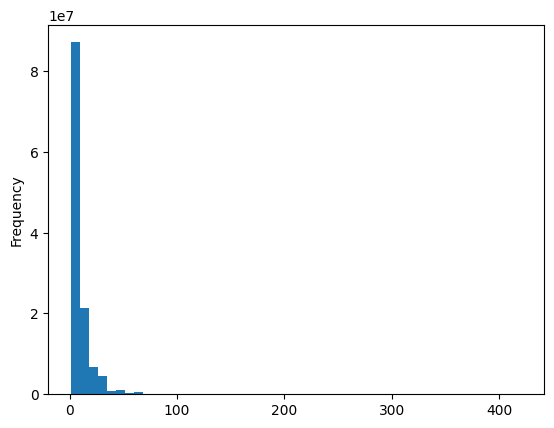

In [155]:
dist_df["distance"].plot.hist(bins = 50)